<a href="https://colab.research.google.com/github/rizwannitk/machinelearning/blob/main/sparkml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!apt-get install -y openjdk-8-jdk-headless -qq

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" 

In [4]:
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [5]:
!java -version

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)


In [6]:

!pip install pyspark

     |████████████████████████████████| 204.2MB 72kB/s 
     |████████████████████████████████| 204kB 39.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=3d53ec7217199cdceb952d5eef42fc88c250cf22c28d0be386d460582329f4cf
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [7]:
!pip install pyarrow==0.15.1

     |████████████████████████████████| 59.2MB 78kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [9]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [10]:
type(spark)

pyspark.sql.session.SparkSession

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv')

In [12]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().any())
print ("\nUnique values :  \n",df.nunique())

Rows     :  500
Columns  :  3

Features : 
 ['date', 'store_id', 'sales']

Missing values :   date        False
store_id    False
sales       False
dtype: bool

Unique values :  
 date         50
store_id     10
sales       500
dtype: int64


In [13]:
df.head()

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000


In [14]:
df["date"]=pd.to_datetime(df["date"],infer_datetime_format=True)

In [15]:
df_base = df.copy()

In [16]:
df_base.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [18]:
df["store_id"].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [19]:
item_df=df.set_index("date")

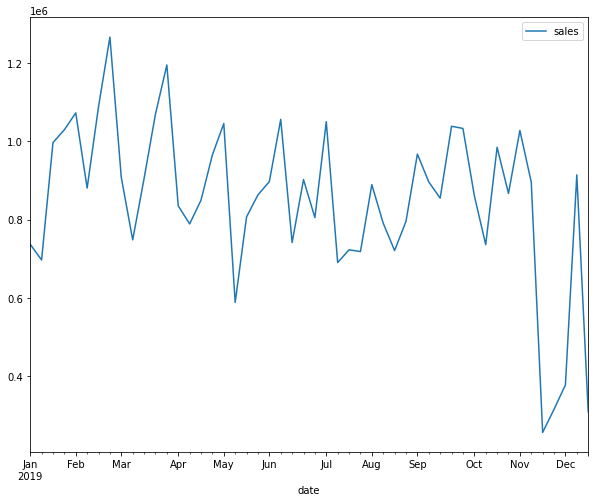

In [23]:
item_df.query("store_id==25")[["sales"]].plot()

In [24]:
sdf = spark.createDataFrame(df)

In [25]:
sdf

DataFrame[date: timestamp, store_id: bigint, sales: double]

In [26]:
sdf.show()

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
|2019-01-06 00:00:00|      31|837342.8156|
|2019-01-06 00:00:00|      35|   201013.6|
|2019-01-06 00:00:00|      38|  242397.03|
|2019-01-06 00:00:00|      41|   244189.4|
|2019-01-06 00:00:00|      44|   164553.5|
|2019-01-13 00:00:00|      25|696457.1717|
|2019-01-13 00:00:00|      26|  261136.45|
|2019-01-13 00:00:00|      28|  787359.03|
|2019-01-13 00:00:00|      29|   279218.0|
|2019-01-13 00:00:00|      30|  252519.59|
|2019-01-13 00:00:00|      31|836604.5717|
|2019-01-13 00:00:00|      35| 277550.185|
|2019-01-13 00:00:00|      38| 215895.275|
|2019-01-13 00:00:00|      41|   231992.5|
|2019-01-13 00:00:00|      44|   134188.0|
+----------

In [27]:
sdf.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [28]:
sdf.count()

500

In [31]:
#sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [32]:
sdf.createOrReplaceTempView("sales")

In [33]:
spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [34]:
sql = 'SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'

In [35]:
spark.sql(sql).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


In [36]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [39]:
sdf.rdd.getNumPartitions()

1

In [38]:
store_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

In [40]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [41]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('store_id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

In [42]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):

  model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=5, 
    freq='w'
    )
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]

In [43]:
from pyspark.sql.functions import current_date

results = (
  store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date() )
    )

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [44]:
results.show()

+-------------------+--------+------------------+------------------+------------------+-----------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_upper|       yhat_lower|training_date|
+-------------------+--------+------------------+------------------+------------------+-----------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818| 936956.4524630198|475096.2063836026|   2020-12-05|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 965876.5876192765|503562.8997221712|   2020-12-05|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606|1195277.4953785625|744531.1475626396|   2020-12-05|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566|1276423.1859308672| 776458.188045089|   2020-12-05|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249| 1213796.646979198|752225.2354045012|   2020-12-05|
|2019-02-10 00:00:00|      25|       880